In [1]:
import pandas as pd
import plotly.express as px
import numpy as np 
import os
import matplotlib.pyplot as plt
import ast
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the path to your results folder
results_folder_path = r"C:\Users\krtej\Jupyter_folder\Standalone Projects\Results"

# Initialize empty DataFrames for each type
day_df = pd.DataFrame()
minute60_df = pd.DataFrame()
minute38_df = pd.DataFrame()

# Iterate through all folders in the results folder
for folder_name in os.listdir(results_folder_path):
    folder_path = os.path.join(results_folder_path, folder_name)
    
    # Check if the item in the folder is a directory
    if os.path.isdir(folder_path):
        
        # Read the three DataFrames from each folder
        day = pd.read_csv(os.path.join(folder_path, 'day.csv'))
        minute60 = pd.read_csv(os.path.join(folder_path, '60minute.csv'))
        minute38 = pd.read_csv(os.path.join(folder_path, '38minute.csv'))
        
        # Add a new column with the folder name
        day['Folder'] = folder_name
        minute60['Folder'] = folder_name
        minute38['Folder'] = folder_name
        
        # Concatenate the DataFrames
        day_df = pd.concat([day_df, day], ignore_index=True)
        minute60_df = pd.concat([minute60_df, minute60], ignore_index=True)
        minute38_df = pd.concat([minute38_df, minute38], ignore_index=True)

# Now, day_df, minute60_df, and minute38_df contain the combined data with an extra 'Folder' column

In [3]:
def process_dataframes(day_df):
    # Create a dictionary to store DataFrames for each group
    dfs = {}
    
    # Group by 'Profit_Loss_Windows'
    grouped_df = day_df.groupby('Profit_Loss_Windows')
    
    # Populate the dictionary with grouped DataFrames
    for name, group in grouped_df:
        dfs[name] = group.drop(columns=['Profit_Loss_Windows']).copy()
    
    # Define a function to safely convert cell values to lists
    def convert_to_list(cell_value):
        try:
            return ast.literal_eval(cell_value)
        except (SyntaxError, ValueError):
            return cell_value
    
    # Apply convert_to_list to all DataFrames in the dictionary
    for key, df in dfs.items():
        dfs[key] = df.applymap(convert_to_list)
    
    # Define a function to extract the fourth element from a list
    def extract_fourth_element(lst):
        return lst[3] if len(lst) >= 4 else None
    
    # Extract the fourth element from each DataFrame in the dictionary
    for key, df in dfs.items():
        # Apply the function to all columns except the last one
        df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda col: col.map(extract_fourth_element))
    
    return dfs

In [4]:
day_dfs = process_dataframes(day_df)

In [5]:
day_dfs

{'(1, 0.33)':       ACC ADANIENT ADANIGREEN ADANIPORTS AMBUJACEM APOLLOHOSP ASIANPAINT  \
 0   32.61    58.14      28.57      57.41     44.44      42.22      53.33   
 4   32.26     50.0      14.29       50.0     43.75      42.42      45.45   
 8   34.09    57.14      28.57       58.0      45.1      40.91      51.22   
 12  47.83     45.0       37.5      36.67     34.62      21.74      59.26   
 16    0.0     50.0        0.0      33.33     100.0      100.0        0.0   
 20    0.0      0.0      100.0        0.0       0.0      100.0        0.0   
 24   25.0    33.33      100.0        0.0      40.0      33.33       50.0   
 28  40.66    47.92      33.33      42.27     56.79      47.06      41.27   
 
    AUROPHARMA AXISBANK BAJAJ-AUTO  ...    TCS  TECHM  TITAN TORNTPHARM  \
 0       48.05     45.1      43.86  ...  47.83  51.02  43.48      54.17   
 4       42.31    38.71      37.84  ...  51.61  45.45  36.36      51.72   
 8       48.65     44.0      44.64  ...  45.45  51.06  39.53      5

In [6]:
def plot_profitability(dfs):
    for df_name, df in dfs.items():
        # Extract company names and folder values
        companies = df.iloc[:, :-1]
        folders = df.iloc[:, -1]

        # Create a DataFrame for plotting
        plot_data = pd.DataFrame(columns=['Company', 'Folder', 'Value'])

        for company in companies.columns:
            company_data = pd.DataFrame({
                'Company': [company] * len(folders),
                'Folder': folders.values,
                'Value': df[company]
            })
            plot_data = pd.concat([plot_data, company_data])

        # Convert 'Folder' column to categorical with specified order
        plot_data['Folder'] = pd.Categorical(plot_data['Folder'], categories=sorted(folders.unique()))

        # Calculate average values for each company
        avg_values = plot_data.groupby('Company')['Value'].mean().reset_index()
        avg_values_company = plot_data.groupby('Company')['Value'].mean().reset_index()

        # Calculate the overall mean
        overall_mean = plot_data['Value'].mean()

        # Plotting using Plotly
        fig = px.scatter(plot_data, x='Company', y='Value', color='Folder',
                         title=f'Scatter Plot for {df_name}',
                         labels={'Value': 'Percentage of Profitable Trades'})
        fig.add_trace(px.line(avg_values, x='Company', y='Value').update_traces(line=dict(color='red', dash='dash'))['data'][0])
        fig.add_trace(px.line(x=avg_values_company['Company'], y=[overall_mean] * len(avg_values_company)).update_traces(line=dict(color='black', dash='dash'))['data'][0])
        fig.add_annotation(x=avg_values_company['Company'].iloc[-1], y=overall_mean,
                           text=f'Mean Profit: {overall_mean:.2f}', showarrow=True,
                           arrowhead=4, ax=0, ay=50)
        # Rotate x-axis labels for better readability
        fig.update_layout(xaxis=dict(tickangle=45, tickmode='array'))

        # Show the plot
        fig.show()

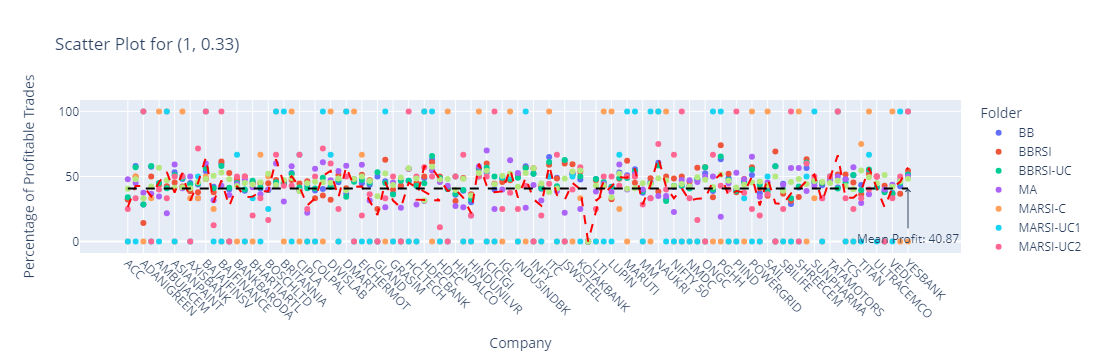

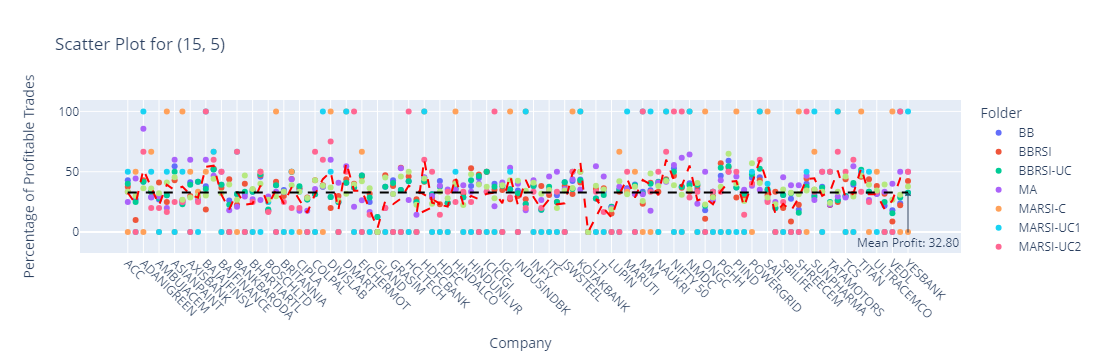

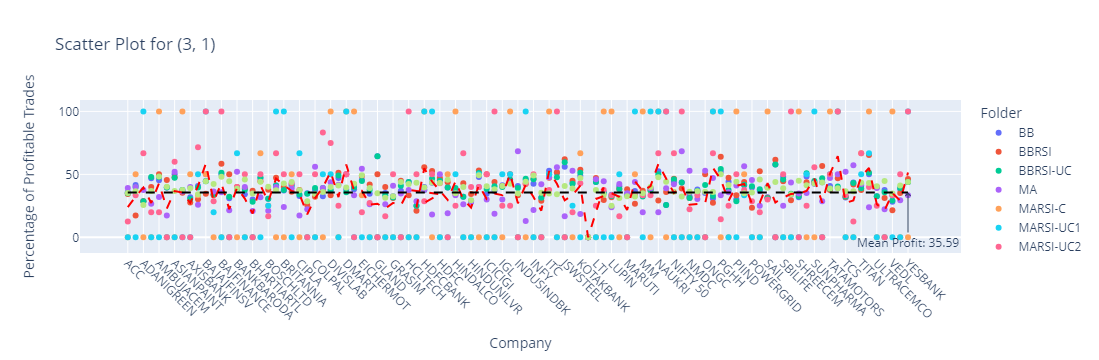

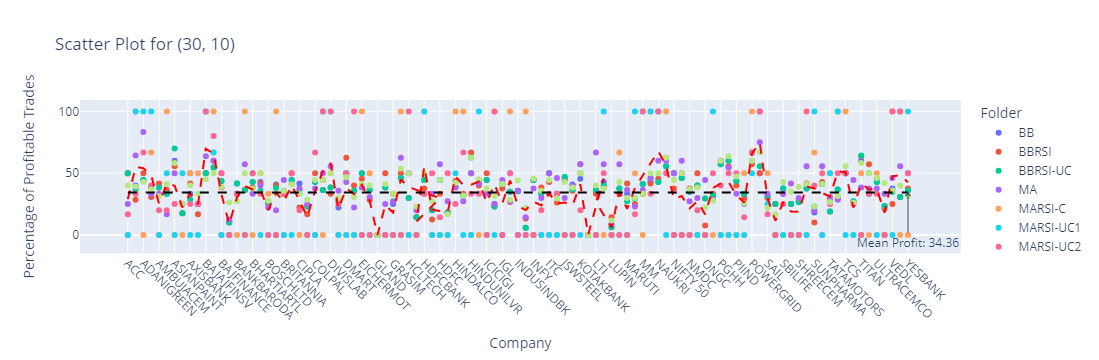

In [7]:
plot_profitability(day_dfs)

In [8]:
hour_dfs = process_dataframes(minute60_df)

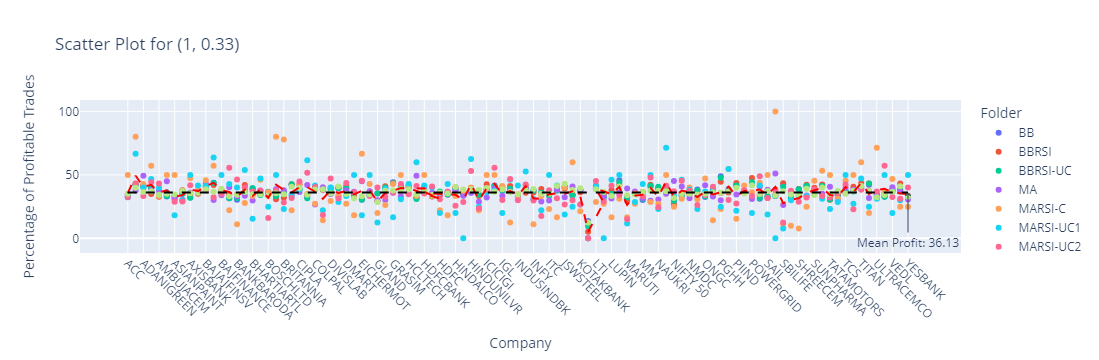

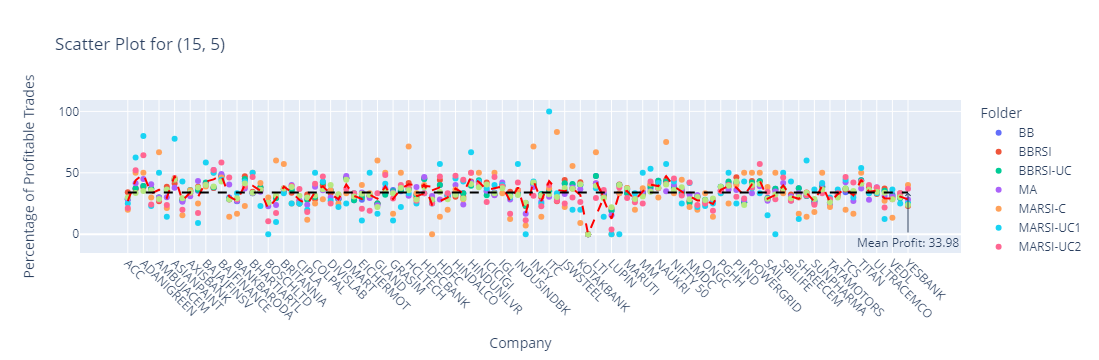

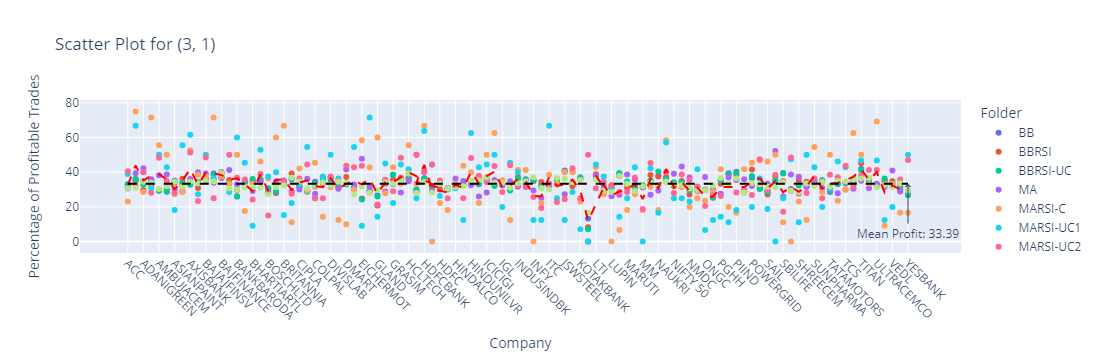

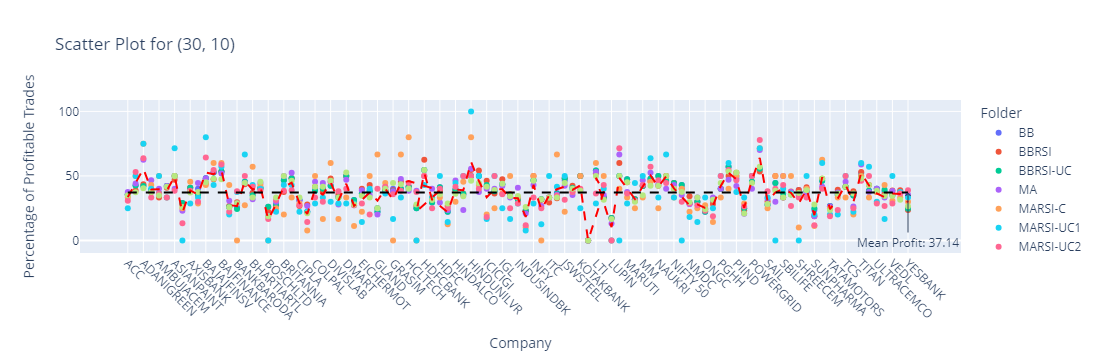

In [9]:
plot_profitability(hour_dfs)

In [10]:
uncon_dfs = process_dataframes(minute38_df)

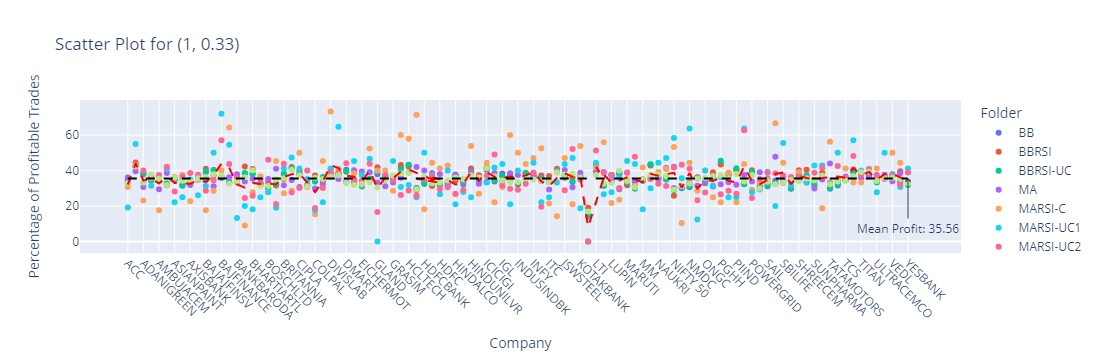

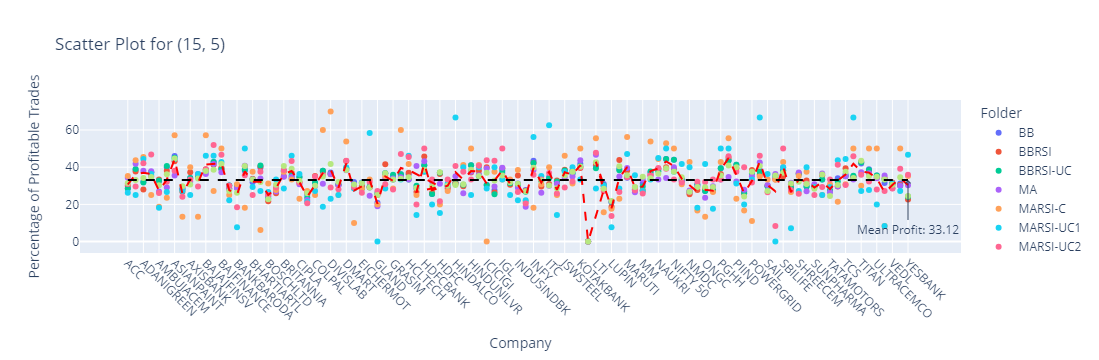

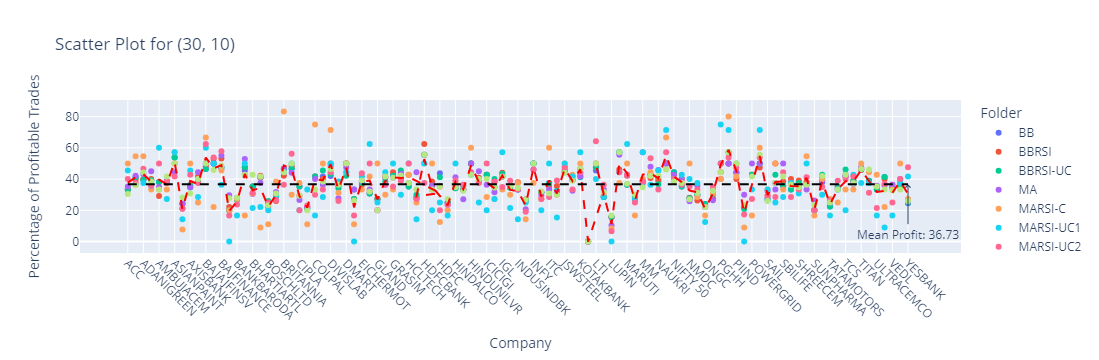

In [11]:
plot_profitability(uncon_dfs)

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_profitability(dfs):
    for df_name, df in dfs.items():
        # Extract company names and folder values
        companies = df.iloc[:, :-1]
        folders = df.iloc[:, -1]

        # Create a DataFrame for plotting
        plot_data = pd.DataFrame(columns=['Company', 'Folder', 'Value'])

        for company in companies.columns:
            company_data = pd.DataFrame({
                'Company': [company] * len(folders),
                'Folder': folders.values,
                'Value': df[company]
            })
            plot_data = pd.concat([plot_data, company_data])

        # Convert 'Folder' column to categorical with specified order
        plot_data['Folder'] = pd.Categorical(plot_data['Folder'], categories=sorted(folders.unique()))

        # Calculate average values for each company
        avg_values = plot_data.groupby('Company')['Value'].mean().reset_index()
        avg_values_company = plot_data.groupby('Company')['Value'].mean().reset_index()

        # Calculate the overall mean
        overall_mean = plot_data['Value'].mean()

        # Plotting using Seaborn
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(40, 8), gridspec_kw={'height_ratios': [5, 3]})

        # Scatter Plot
        sns.scatterplot(data=plot_data, x='Company', y='Value', hue='Folder', ax=axes[0])
        axes[0].set_title(f'Scatter Plot for {df_name}')
        axes[0].set_ylabel('Percentage of Profitable Trades')
        axes[0].legend(title='Folder', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Dotted Line Plots
        sns.lineplot(data=avg_values, x='Company', y='Value', ax=axes[1], color='red', linestyle='dashed', label='Average Value')
        sns.lineplot(data=avg_values_company, x='Company', y=overall_mean, ax=axes[1], color='black', linestyle='dashed', label='Overall Mean')
        axes[1].set_xlabel('Company')
        axes[1].set_ylabel('Value')
        axes[1].legend()

        # Rotate x-axis labels for better readability
        # plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)
        axes[0].set_xticks([])
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        plt.show()



In [33]:
plot_profitability(hour_dfs)